### What we will learn

- We will build our first HelloWorld Kubeflow Pipeline!
- We will show how to compile pipeline function into template
- We will push template into Artifact Repository
- We will show how to execute Pipeline Job using Vertex AI SDK
- We will show how to execute Pipeline Job from templates uploaded to Artifact Repository using Vertex AI

In [1]:
import kfp

In [5]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [3]:
! pwd

/home/jupyter/ccc


In [14]:
import os
PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
BUCKET_NAME = os.environ.get('BUCKET_NAME')
REGION = os.environ.get('VERTEXAI_REGION')
GCP_ARTIFACT_REPO_NAME="ccc-workshop-vertexai-pipelines"

PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

print(PROJECT_ID)
print(BUCKET_NAME)
print(PIPELINE_ROOT)
print(REGION)

PIPELINE_PARAMETERS = {}
LABELS = {}

ENABLE_CACHING=True

datafusionsbox
gcp-demo-ccc-vertexai
gs://gcp-demo-ccc-vertexai/pipeline_root
us-central1


In [7]:
from kfp.v2.dsl import component

In [9]:
@component
def helloworld():
    print("Hello World")

In [10]:
from kfp.dsl import pipeline

@pipeline(name="wf-ccc-ex1")
def pipeline():
    task = helloworld()

### Compile and run pipeline

In [11]:
from kfp.v2 import compiler

In [12]:
dag_yaml_filename = "dag_ccc_ex1.yaml"

compiler.Compiler().compile(
   pipeline_func=pipeline,        ##input
   package_path=dag_yaml_filename ##output
)

In [15]:
from google.cloud import aiplatform

job = aiplatform.PipelineJob(display_name = "kfp_pipeline_ccc_ex1",
                             template_path = dag_yaml_filename,
                             pipeline_root = PIPELINE_ROOT,
                             parameter_values = PIPELINE_PARAMETERS, ## Make sure PIPELINE_PARAMETERS collection does not include parameters that are unknown to pipeline
                             enable_caching = ENABLE_CACHING,
                             #encryption_spec_key_name = CMEK,
                             labels = LABELS,
                             project = PROJECT_ID,
                             location = REGION)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

Creating PipelineJob
PipelineJob created. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207153418
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207153418')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/wf-ccc-ex1-20230207153418?project=339239659794
PipelineJob run completed. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207153418


### Upload pipeline template to Artifact Registry (Kubeflow Pipeline)

In [16]:
from kfp.registry import RegistryClient

In [17]:
client = RegistryClient(host=f"https://us-central1-kfp.pkg.dev/{PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}")

In [18]:
templateName, versionName = client.upload_pipeline(
  file_name=dag_yaml_filename,
  tags = ["v1", "latest"]
)

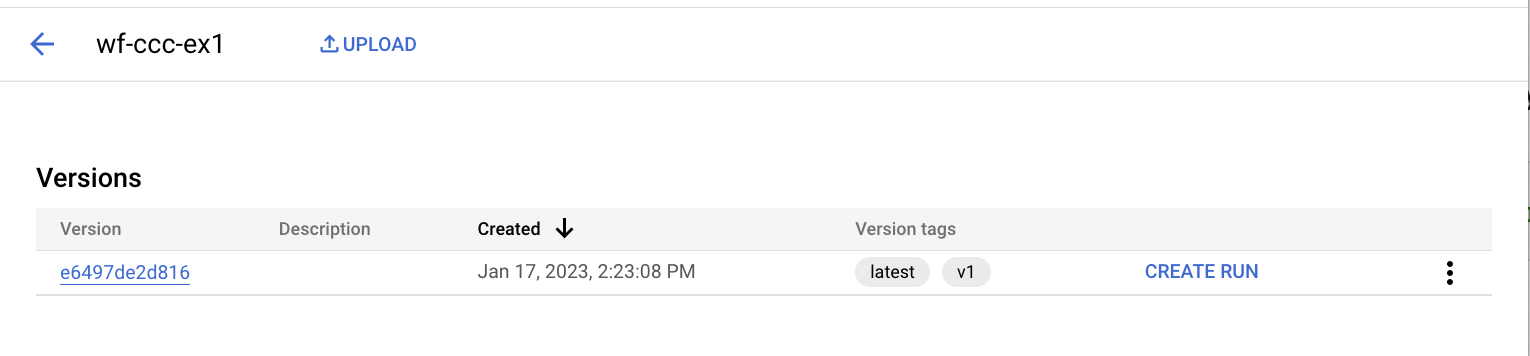

In [19]:
packages = client.list_packages()
packages

[{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1',
  'createTime': '2023-01-17T12:47:07.063487Z',
  'updateTime': '2023-02-07T15:37:45.653791Z'}]

In [20]:
versions = client.list_versions(package_name = packages[0]['name'].split('/')[-1])
versions

[{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1/versions/sha256:17f965dbb0628f751a53be4ce292d806f55a3ab685f49175a8aa714720226187',
  'createTime': '2023-02-07T15:37:45.653791Z',
  'updateTime': '2023-02-07T15:37:45.653791Z',
  'relatedTags': [{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1/tags/latest',
    'version': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1/versions/sha256:17f965dbb0628f751a53be4ce292d806f55a3ab685f49175a8aa714720226187'},
   {'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1/tags/v1',
    'version': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-workshop-vertexai-pipelines/packages/wf-ccc-ex1/versions/sha256:17f965dbb0628f751a53be4ce292d806f55a3ab685f49175a8aa71472022

In [24]:
artifact_name = dag_yaml_filename.split('.')[0]
artifact_name

'dag_ccc_ex1'

In [25]:
package_name = packages[0]['name'].split('/')[-1]
package_name

'wf-ccc-ex1'

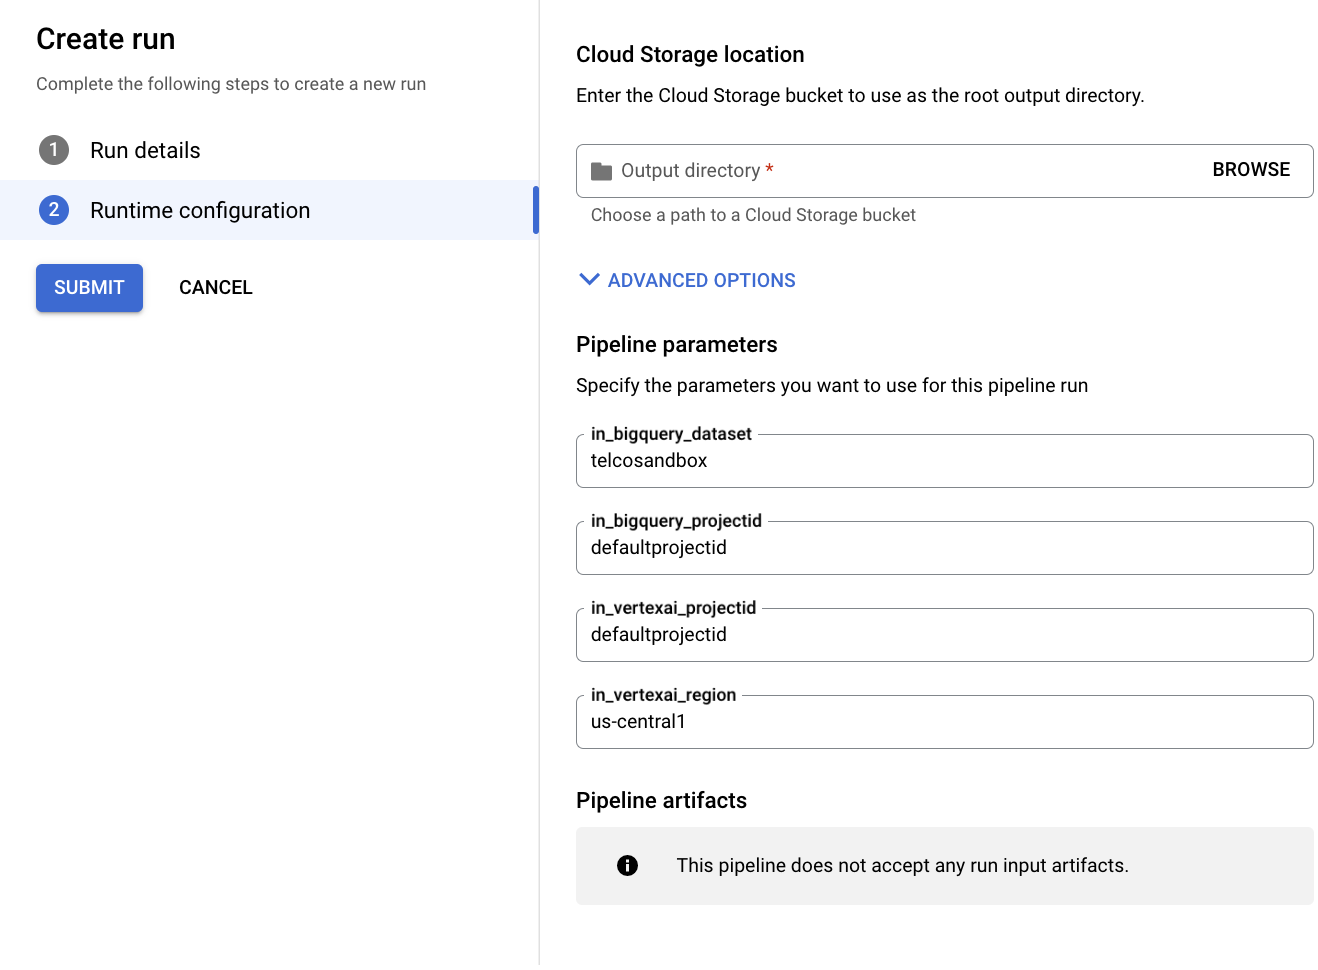

## Run pipeline template (specific version)

In [26]:
from google.cloud import aiplatform
versionName = versions[0]['name'].split('/')[-1]

template_path = f"https://us-central1-kfp.pkg.dev/{PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{versionName}"
print(template_path)

job = aiplatform.PipelineJob(
    display_name="hello-world-latest",
    template_path=f"https://us-central1-kfp.pkg.dev/{PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{versionName}"
)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

https://us-central1-kfp.pkg.dev/datafusionsbox/ccc-workshop-vertexai-pipelines/wf-ccc-ex1/sha256:17f965dbb0628f751a53be4ce292d806f55a3ab685f49175a8aa714720226187
Creating PipelineJob
PipelineJob created. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207154159
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207154159')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/wf-ccc-ex1-20230207154159?project=339239659794
PipelineJob run completed. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230207154159


## Run pipeline template (specific tag)

In [16]:
from google.cloud import aiplatform
tagName = "latest"
template_path = f"https://us-central1-kfp.pkg.dev/{PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{tagName}"
print(template_path)
job = aiplatform.PipelineJob(
    display_name="hello-world-latest",
    template_path=template_path,
    parameter_values = PIPELINE_PARAMETERS, ## Make sure PIPELINE_PARAMETERS collection does not include parameters that are unknown to pipeline
    enable_caching = ENABLE_CACHING,
    #encryption_spec_key_name = CMEK,
    labels = LABELS,
    project = PROJECT_ID,
    location = REGION
)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

https://us-central1-kfp.pkg.dev/datafusionsbox/ccc-workshop-vertexai-pipelines/dag_ccc_ex1/latest


HTTPError: HTTP Error 404: Not Found